BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/share/home/pwmat/anaconda3/envs/llm/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no se

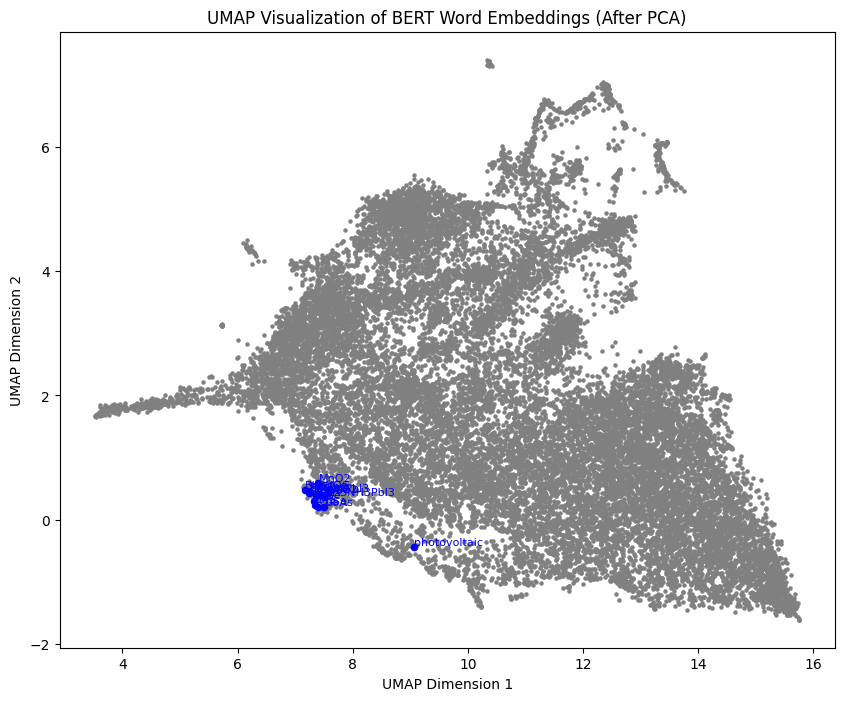

In [1]:
import numpy as np
from sklearn.manifold import TSNE
import torch
from transformers import BertConfig, BertModel, BertTokenizer
from transformers import BertForMaskedLM, BertTokenizerFast, pipeline
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

model_id = "/share/home/pwmat/Huggingface_Model_Downloades/MatBERT_model/matbert-base-cased"
model = BertForMaskedLM.from_pretrained(model_id)
tokenizer = BertTokenizerFast.from_pretrained(model_id, do_lower_case=False)

# 提取所有词向量
all_word_embeddings = []
all_words = []
for word in tokenizer.vocab.keys():
    if word.isalnum():  # 只选择字母数字组合的词，排除特殊标记
        token_id = tokenizer.encode(word, add_special_tokens=False)
        if len(token_id) == 1:  # 确保词没有分词成多个子词
            token_id = torch.tensor(token_id).unsqueeze(0)
            embeddings = model.bert.embeddings.word_embeddings(token_id)
            all_word_embeddings.append(embeddings.squeeze().detach().numpy())
            all_words.append(word)

all_word_embeddings = np.array(all_word_embeddings)

# 首先使用 PCA 将词向量降至 50 维
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(all_word_embeddings)

# 使用UMAP进行再次降维
reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_umap = reducer.fit_transform(embeddings_pca)

highlighted_words = [
    'photovoltaic', 'GaAs', 'SnS2', 'CdSe', 
    'SnS', 'Bi2Se3', 'CIGSe', 'PbSe', 'CuInS2', 'CuInSe2', 'CIGS', 'MAPbI3', 'CH3NH3PbI3', 
    'Bi2WO6', 'ZnS', 'SnO2', 'MnO2'
]

# 将所有坐标转换为单个数组
x_coords = embeddings_umap[:, 0]
y_coords = embeddings_umap[:, 1]

# 批量绘制所有点
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, color='gray', s=5)

# 标记高亮词汇
for word in highlighted_words:
    if word in all_words:
        idx = all_words.index(word)
        plt.scatter(embeddings_umap[idx, 0], embeddings_umap[idx, 1], color='blue', s=20)
        plt.text(embeddings_umap[idx, 0], embeddings_umap[idx, 1], word, fontsize=8, ha='left', va='bottom', color='blue')

plt.title('UMAP Visualization of BERT Word Embeddings (After PCA)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.savefig('allword_highlight_improved.png')
plt.show()


In [2]:
from sklearn.metrics.pairwise import cosine_similarity
# 计算所有词向量与"perovskite"的余弦相似度
word5_token = tokenizer.encode("photovoltaic", add_special_tokens=False)
word5_embedding = model.bert.embeddings.word_embeddings(torch.tensor(word5_token)).squeeze().detach().numpy()
cos_similarities1 = cosine_similarity(all_word_embeddings, [word5_embedding])

In [3]:
print("silicon" in all_words)

True


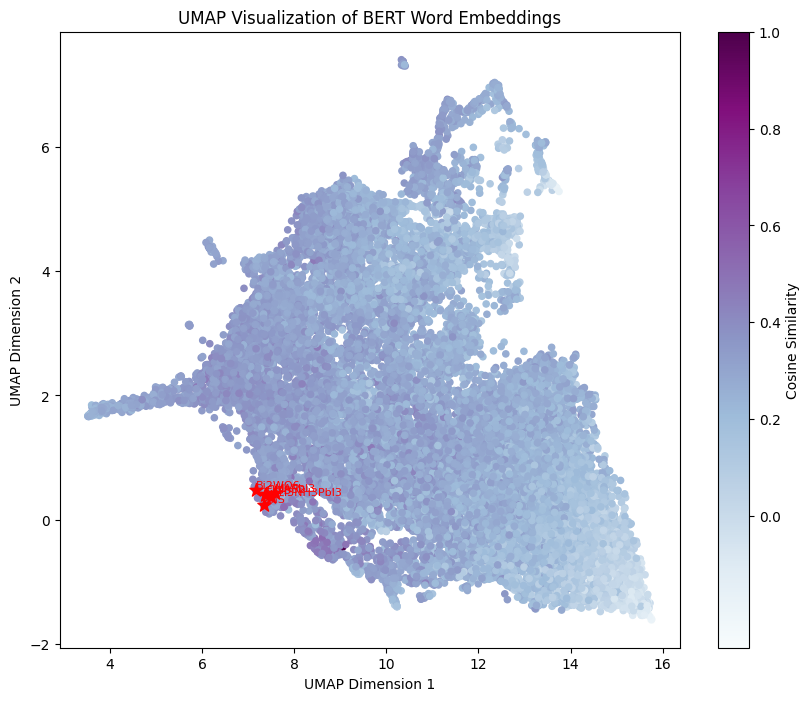

In [4]:
# 可视化降维后的词向量，并根据余弦相似度调整颜色深浅
plt.figure(figsize=(10, 8))
cmap = plt.cm.BuPu
scatter=plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=cos_similarities1.squeeze(), cmap=cmap, s=20)

# 标记高亮词汇
highlighted_words = [
    'CuInS2', 'CuInSe2', 'CIGS', 'MAPbI3', 'CH3NH3PbI3', 
    'Bi2WO6', 'ZnS'
]  # "MAPbI3", 'CH3NH3PbI3'
for word in highlighted_words:
    if word in all_words:
        idx = all_words.index(word)
        plt.scatter(embeddings_umap[idx, 0], embeddings_umap[idx, 1], color='red', marker='*', s=100)
        plt.text(embeddings_umap[idx, 0], embeddings_umap[idx, 1], word, fontsize=8, ha='left', va='bottom', color='red')

plt.title('UMAP Visualization of BERT Word Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('Cosine Similarity')

# 设置颜色条的范围，使其只显示蓝色部分
cbar.set_ticks(np.linspace(0, 1, 6))

# plt.axis([-50, 50, -60, 60])




plt.savefig("figure3_word_embeddings_visualization.png")
plt.show()

In [5]:
import plotly.graph_objs as go
import numpy as np

# 假设 embeddings_umap, cos_similarities1, all_words, and highlighted_words 都已定义
# 创建scatter图
trace = go.Scatter(
    x=embeddings_umap[:, 0],
    y=embeddings_umap[:, 1],
    mode='markers',
    marker=dict(
        color=cos_similarities1.squeeze(),  # 使用余弦相似度作为颜色值
        colorscale='BuPu',  # 配色方案
        size=10,  # 点的大小
        showscale=True  # 显示颜色条
    ),
    text=all_words,  # 每个点显示对应的词汇
    hoverinfo='text'  # 鼠标悬停显示词汇
)

# 创建高亮词汇的scatter图
highlight_traces = []
for word in highlighted_words:
    if word in all_words:
        idx = all_words.index(word)
        highlight_traces.append(go.Scatter(
            x=[embeddings_umap[idx, 0]],
            y=[embeddings_umap[idx, 1]],
            mode='markers+text',
            marker=dict(
                color='limegreen',
                size=8,
                symbol='circle',
                opacity=1
            ),
            text=[word],
            textposition='top right',
            hoverinfo='text'
        ))

# 将普通点和高亮点合并
data = [trace] + highlight_traces

# 创建布局
layout = go.Layout(
    title='UMAP Visualization of BERT Word Embeddings',
    xaxis=dict(title='UMAP Dimension 1'),
    yaxis=dict(title='UMAP Dimension 2'),
    hovermode='closest',  # 悬停时显示数据
    showlegend=False,  # 不显示图例
    margin=dict(l=20, r=20, t=50, b=50)  # 设置边距
)

# 创建图表对象
fig = go.Figure(data=data, layout=layout)

# 保存为高分辨率SVG文件
fig.write_image("figure3_word_embeddings_visualization.svg", width=1920, height=1080, scale=10)

# 保存为交互式HTML文件
fig.write_html("figure3_word_embeddings_interactive.html")



In [13]:
# 新增代码块：计算指定化学式在UMAP降维空间中的欧氏距离

# 用户可在此处修改需要比较的两个化学式
word1 = "Bi2WO6"  # 第一个化学式（可修改）
word2 = "GaAs"  # 第二个化学式（可修改）

# 检查词汇是否存在
if word1 not in all_words or word2 not in all_words:
    missing_words = []
    if word1 not in all_words:
        missing_words.append(word1)
    if word2 not in all_words:
        missing_words.append(word2)
    print(f"以下词汇未找到: {missing_words}，请检查拼写或大小写！")
else:
    # 获取对应的UMAP坐标
    idx1 = all_words.index(word1)
    idx2 = all_words.index(word2)
    coord1 = embeddings_umap[idx1]
    coord2 = embeddings_umap[idx2]
    
    # 计算欧氏距离
    distance = np.linalg.norm(coord1 - coord2)
    
    # 输出结果
    print(f"【{word1}】与【{word2}】在UMAP空间的欧氏距离: {distance:.4f}")

【Bi2WO6】与【GaAs】在UMAP空间的欧氏距离: 0.4424
